In [88]:
import os
import urllib, cStringIO

import pymongo as pm

from IPython.display import clear_output

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)   

### load in model param posterior (bdaOutput/**splitbyobjectParams.csv)

#### make loglikelihood plot for human encoder version

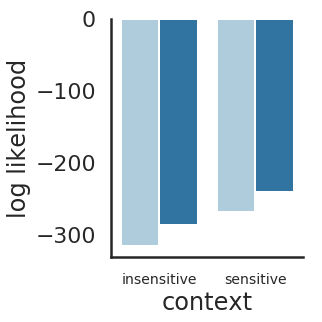

In [89]:
model_prefixes = ['human']
PP = h.model_comparison_bars(model_prefixes,adaptor_type='human',split_type='balancedavg1')
h.plot_human_bars(PP)

In [90]:
PP

,model,logLikelihood,perception,pragmatics,production
0,human_S0_cost,-287.138499,human,S0,cost
1,human_S0_nocost,-316.320149,human,S0,nocost
2,human_combined_cost,-240.794297,human,combined,cost
3,human_combined_nocost,-269.563112,human,combined,nocost


#### make loglikelihood plot for multimodal convnet encoder version

In [91]:
adaptor_type = 'multimodal_fc6'
split_type = 'balancedavg1'
model_prefixes = [adaptor_type]
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_fc6_S0_cost,-560.161659,multimodal,fc6,S0,cost
1,multimodal_fc6_S0_nocost,-561.270152,multimodal,fc6,S0,nocost
2,multimodal_fc6_combined_cost,-452.254866,multimodal,fc6,combined,cost
3,multimodal_fc6_combined_nocost,-460.554496,multimodal,fc6,combined,nocost


In [92]:
adaptor_type = 'multimodal_conv42'
split_type = 'balancedavg1'
model_prefixes = ['multimodal_conv42']
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_conv42_S0_cost,-752.464675,multimodal,conv42,S0,cost
1,multimodal_conv42_S0_nocost,-756.505671,multimodal,conv42,S0,nocost
2,multimodal_conv42_combined_cost,-695.382719,multimodal,conv42,combined,cost
3,multimodal_conv42_combined_nocost,-698.864526,multimodal,conv42,combined,nocost


In [93]:
adaptor_type = 'multimodal_pool1'
split_type = 'balancedavg1'
# model_prefixes = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
model_prefixes = ['multimodal_pool1']
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_pool1_S0_cost,-1110.380258,multimodal,pool1,S0,cost
1,multimodal_pool1_S0_nocost,-1110.246551,multimodal,pool1,S0,nocost
2,multimodal_pool1_combined_cost,-1097.753596,multimodal,pool1,combined,cost
3,multimodal_pool1_combined_nocost,-1098.316452,multimodal,pool1,combined,nocost


#### check that distribution of log likelihoods is higher for the cost version of the model vs. nocost version

In [94]:
reallyRun = 0
if reallyRun:
    h.check_mean_LL_for_cost_vs_nocost(model_prefixes=['multimodal_fc6'],
                                         adaptor_type = 'multimodal_fc6',
                                         split_type='balancedavg1',
                                         plot=True)

### Run evaluate to get scores on the test set

In [95]:
### FIRST STEP:
### iterate through Params and write back out in "flattened" form
reload(h)
reallyRun = 0
if reallyRun:
    h.flatten_param_posterior(adaptor_types = ['multimodal_pool1','multimodal_conv42','multimodal_fc6', 'human'],
                              verbosity=1)

In [96]:
#### SECOND STEP: Go to RSA.py and run evaluate on all of the models and splits
### e.g.,
### python RSA.py --wppl evaluate --perception human --pragmatics combined S0 --production cost nocost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_fc6 --pragmatics combined S0 --production cost nocost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_conv42 --pragmatics combined S0 --production cost nocost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_pool1 --pragmatics combined S0 --production cost nocost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5

In [97]:
### OPTIONAL: prior to running bda-enumerate, wouldn't it help to get a sense for the extreme values
### in the param posterior for each model, for each split to make sure our grid covers 
### everywhere where there is some mass in the posterior?
reload(h)
reallyRun = 0
if reallyRun:
    h.get_sense_for_param_range_across_splits()

## check model predictions 

- Run the script `./get_all_model_predictions.py`, which is a wrapper around 
this script, `./generate_model_predictions.py` to generate csv files that 
summarize key statistics of interest (e.g., target rank, cost)
from model predictions, for each model and data split.
- Next, assess retrieval performance (i.e., rank of correct sketch category)
- Also assess sketch cost across conditions

#### read in predictions and compute retrieval performance

In [132]:
import analysis_helpers as h
reload(h)
print h.load_all_model_preds.__doc__


    Load all model predictions from all five splits into a dictionary called P.
    P is a nested dictionary containing all predictions dataframes for all five primary models of interest and five splits.    
    P.keys() = ['multimodal_conv42_combined_cost', 'human_combined_cost', 'multimodal_fc6_combined_cost', 'multimodal_fc6_S0_cost', 'multimodal_fc6_combined_nocost']
    Nested inside each model are dataframes containing model predictions from each split.    
    


In [133]:
P = h.load_all_model_preds(verbosity=1)

Loading model preds from: human_combined_cost
Loading model preds from: human_S0_cost
Loading model preds from: human_combined_nocost
Loading model preds from: multimodal_fc6_combined_cost
Loading model preds from: multimodal_fc6_S0_cost
Loading model preds from: multimodal_fc6_combined_nocost
Loading model preds from: multimodal_conv42_combined_cost
Loading model preds from: multimodal_pool1_combined_cost


In [134]:
# for i in np.arange(1,6):
#     _P = P['human_combined_cost']['balancedavg{}'.format(i)]
#     print _P.groupby('condition')['cost'].mean()

### Visualize model predictions separately for each split

- `split_types = ['balancedavg1','balancedavg2','balancedavg3','balancedavg4','balancedavg5']`

- `model_space = ['human_combined_cost','human_S0_cost','human_combined_nocost','multimodal_fc6_combined_cost',`
`'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost','multimodal_conv42_combined_cost',`
`'multimodal_pool1_combined_cost]`

- `H = human_combined_cost`
- `H0 = human_S0_cost`
- `H1 = human_combined_nocost`
- `M = multimodal_fc6_combined_cost`
- `M0 = multimodal_conv42_combined_cost` 
    - "effect of perception"
- `M1 = multimodal_fc6_S0_cost` 
    - "effect of pragmatics/context"
- `M2 = multimodal_fc6_combined_nocost` 
    - "effect of production/cost"
- `M3 = multimodal_pool1_combined_cost`
    - "effect of perception, even stronger"

In [135]:
import analysis_helpers as h
reload(h)
sns.set_context('talk')

split_type = 'balancedavg1'

#### What is the rank of the correct sketch category (correct object + correct context) vs. wrong sketch category (correct object + wrong context)?

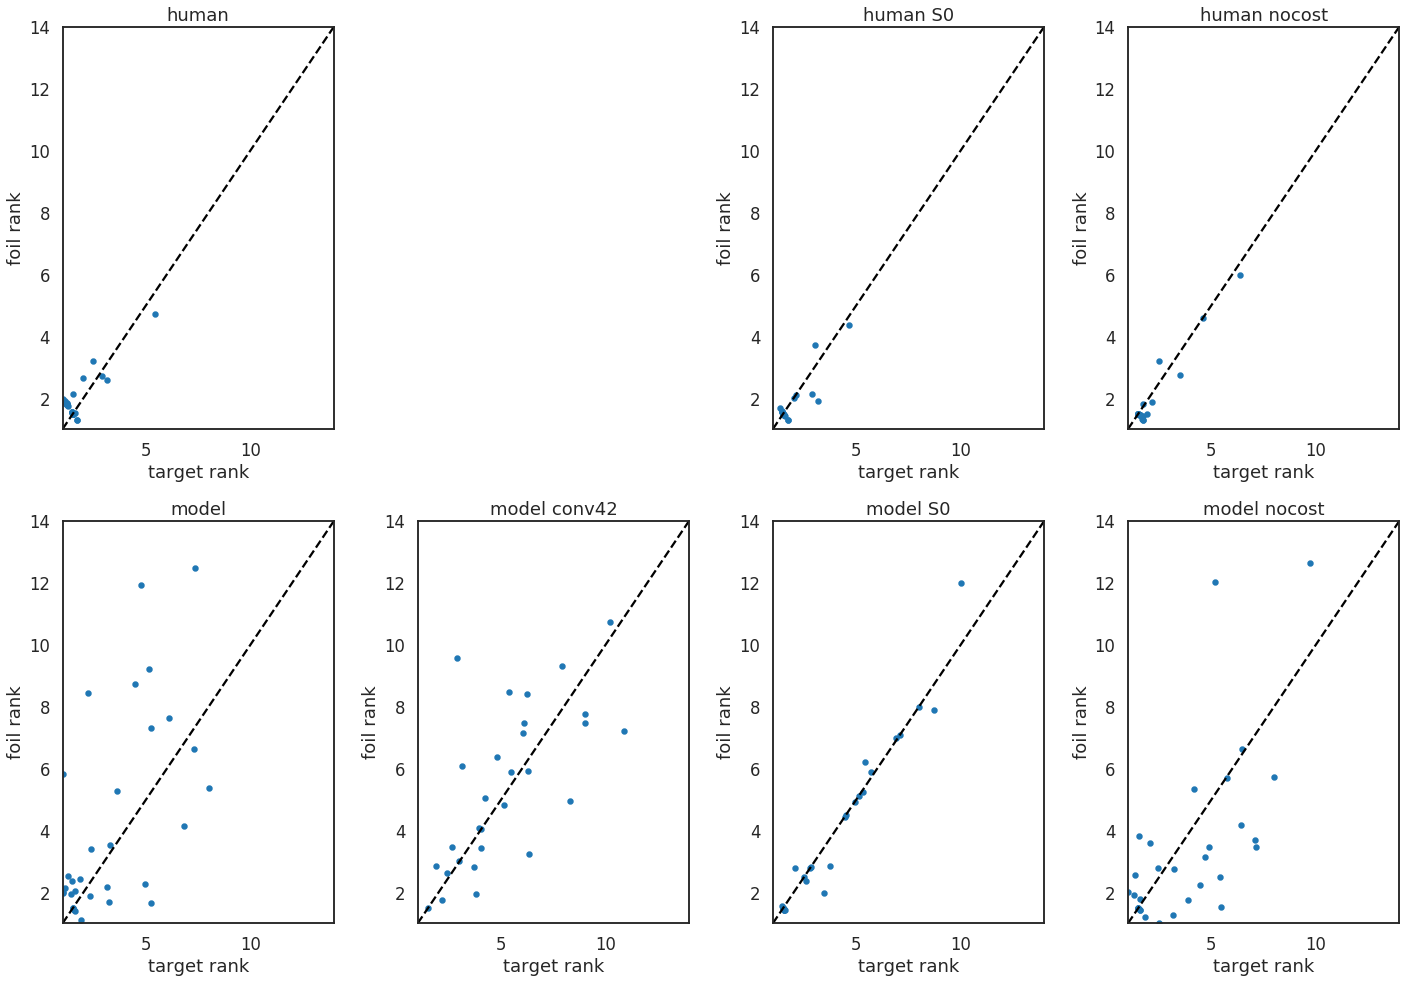

In [136]:
h.plot_target_vs_foil_rank_by_object(P,split_type=split_type)

#### Generate bar plot of average rank (out of 64) of correct sketch category, by model, for a particular split.

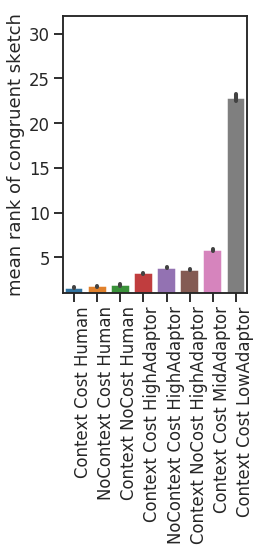

In [137]:
import analysis_helpers as h
reload(h)
h.plot_avg_rank_all_models(P,split_type=split_type)

#### Generate bar plot of proportion of trials for which context-congruent sketch preferred over incongruent sketch.

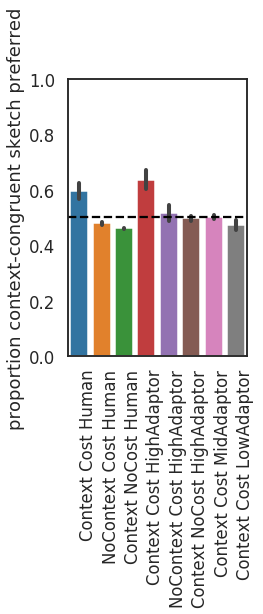

In [138]:
import analysis_helpers as h
reload(h)
h.plot_prop_congruent_all_models(P,split_type=split_type)

#### make a "top-k" plot (what percentage of sketches in the top k)

In [139]:
reallyRun = 0
if reallyRun:
    h.get_top_k_predictions(P,split_type=split_type,verbosity=1)

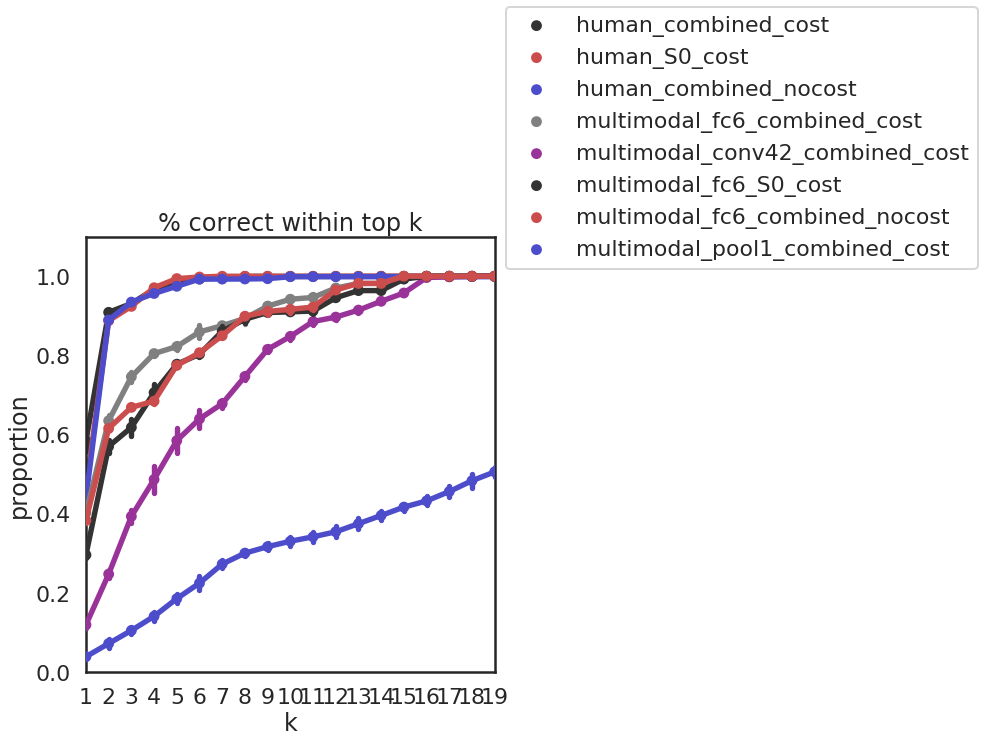

In [140]:
import analysis_helpers as h
reload(h)
h.plot_topk_all_models()

#### What is the average sketch cost by condition and model type?

In [141]:
### show the average cost (time, strokes, ink) for average model prediction

In [153]:
split_type = 'balancedavg1'

In [154]:
import analysis_helpers as h
reload(h)
HU,H0U,H1U,MU,M0U,M1U,M2U,M3U = h.get_avg_cost_all_models(P, split_type=split_type)

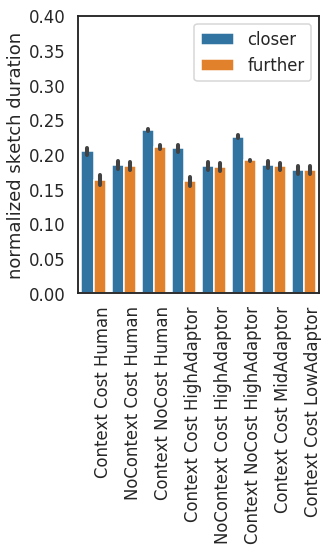

In [155]:
saveout=True
sns.set_context('talk')
fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(111)
U = pd.concat([HU,H0U,H1U,MU,M0U,M1U,M2U,M3U],axis=0)
sns.barplot(data=U,
            x='adaptor',
            y='cost',
            hue='condition',
            ci='sd',
            order=['human_combined_cost','human_S0_cost','human_combined_nocost','multimodal_fc6_combined_cost',
                   'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost','multimodal_conv42_combined_cost', \
                   'multimodal_pool1_combined_cost'])
plt.ylabel('normalized sketch duration')
plt.ylim([0,0.4])
xticklabels=['Context Cost Human','NoContext Cost Human','Context NoCost Human','Context Cost HighAdaptor',
             'NoContext Cost HighAdaptor','Context NoCost HighAdaptor', 'Context Cost MidAdaptor', 'Context Cost LowAdaptor']
plt.xlabel('')
l = ax.set_xticklabels(xticklabels, rotation = 90, ha="left")
plt.legend(bbox_to_anchor=(1., 1.))
plt.tight_layout()
if saveout:
    plt.savefig('./plots/prop_congruent_all_models.pdf')

### Load in bootstrapped model predictions

- First, you want to run `python get_all_bootstrapped_model_predictions.py` to generate a bunch of bootvec output in the directory `bootstrap_results`.

- Next, follow the below code to generate visualizations of estimates of statistics of interest.

In [169]:
import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.pyc'>

In [170]:
## load in boot filelist
boot_files = h.load_and_check_bootstrapped_model_preds()

## generate dataframe from boot filelist
B = h.generate_bootstrap_model_preds_dataframe(boot_files, out_dir='./bootstrap_results')

There are 480 files in the bootstrap_results directory.


### Visualize model predictions aggregating across splits

In [171]:
split_types = ['balancedavg1','balancedavg2','balancedavg3','balancedavg4','balancedavg5']

model_space = ['human_combined_cost','human_S0_cost','human_combined_nocost','multimodal_fc6_combined_cost',\
               'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost','multimodal_conv42_combined_cost',\
               'multimodal_pool1_combined_cost']

vois = list(np.unique(B.var_of_interest.values))

#### Generate bar plot of average rank (out of 64) of correct sketch category, by model, across splits.

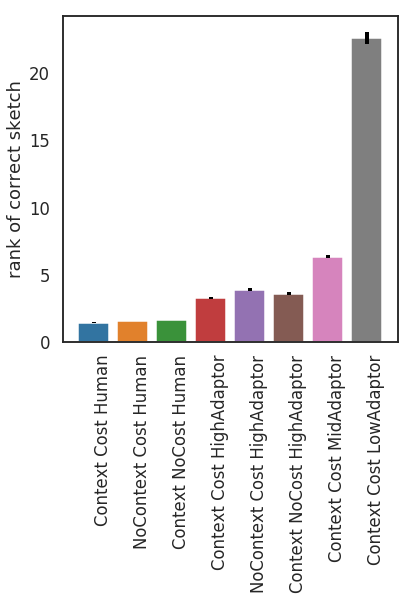

In [179]:
import analysis_helpers as h
reload(h)
## make dataframe
R = h.generate_aggregated_estimate_dataframe(B,
                                             condition_list = ['all'],
                                             model_space=model_space,
                                             split_types=split_types,
                                             var_of_interest='target_rank')

## make plot 
h.plot_average_target_rank_across_splits(R,
                                         var_of_interest='target_rank',
                                         condition_list = ['all'],
                                         model_space=model_space,
                                         split_types=split_types,
                                         condition='all',
                                         sns_context='talk',
                                         figsize=(6,6),
                                         errbar_multiplier=1.,
                                         ylabel='rank of correct sketch')

#### generate barplot for prop congruent sketch category aggregated across splits

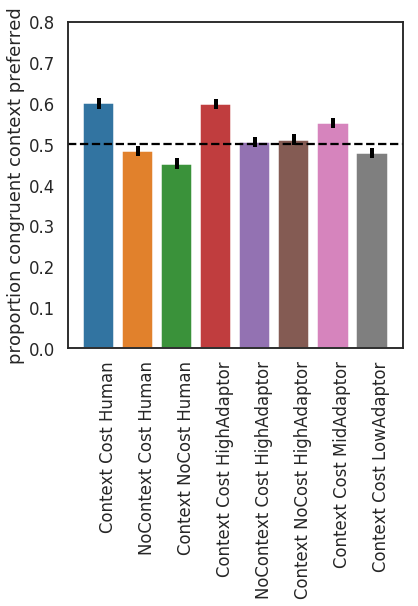

In [180]:
reload(h)
## make dataframe
R = h.generate_aggregated_estimate_dataframe(B,
                                             condition_list = ['all'],
                                             model_space=model_space,
                                             split_types=split_types,
                                             var_of_interest='sign_diff_rank')

## make plot
h.plot_prop_congruent_across_splits(R,
                                    var_of_interest='sign_diff_rank',
                                    condition_list = ['all'],
                                    model_space=model_space,
                                    split_types=split_types,
                                    condition='all',
                                    sns_context='talk',
                                    figsize=(6,6),
                                    errbar_multiplier=1.,
                                    ylabel='proportion congruent context preferred')

#### make barplot of cost x condition aggregated across splits 

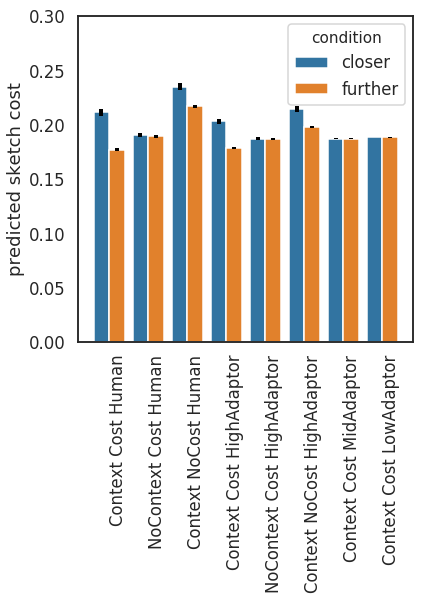

In [181]:
reload(h)
## make dataframe
R = h.generate_aggregated_estimate_dataframe(B,
                                             condition_list = ['closer','further'],
                                             model_space=model_space,
                                             split_types=split_types,
                                             var_of_interest='cost')

## make plot
h.plot_cost_by_condition_across_splits(R,
                                      var_of_interest='cost',
                                      condition_list = ['closer','further'],
                                      model_space=model_space,
                                      split_types=split_types,
                                      condition='all',
                                      sns_context='talk',
                                      figsize=(6,6),
                                      errbar_multiplier=1.,
                                      ylabel='predicted sketch cost')